# Summary



### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['HamiltonianExploration_sinbeta_eta0p25']
#     pr_filenames = ['HamiltonianExploration_sinbeta_eta0p5']
#     pr_filenames = ['HamiltonianExploration_sinbeta_eta1p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, factor, powsimp, expand_power_base, collect, trigsimp, \
                    Rational, Matrix, Eq, poly, nroots, \
                    solve, sin, cos, tan, atan, asin, Abs, sqrt, re, im, N, \
                    numer, denom, expand, Piecewise, lambdify, deg, rad, pi, \
                    diff, sign
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, omitdict, round as gmround, convert
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
from gme.plot import Graphing, SlicingPlots

import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['HamiltonianExploration_sinbeta_eta0p25'])

In [3]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'hamiltonian',
    'subtitle': '',
    'title': 'Exploration of Hamiltonian for sin(beta) erosion model, eta=1/4',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/4,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/2,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 1000}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}

In [4]:
pr.model.varphi_0 = 0.1
pr.model.xiv_0 = 1

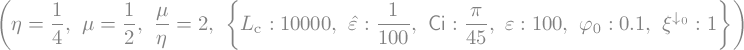

In [5]:
sub = {
        Ci: pr.model.Ci, 
        Lc: pr.model.Lc, 
        varepsilonhat: pr.model.varepsilonhat, 
        varepsilon: pr.model.varepsilonhat*pr.model.Lc, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Theory

## Basics

In [6]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

In [7]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,
                  do_geodesic=False, 
                  parameters=sub, 
                  do_raw=True )

In [8]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
                                    else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1'

## Hamiltonian

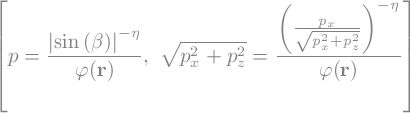

In [9]:
eqns(['p_varphi_beta_eqn', 'p_varphi_pxpz_eqn'])

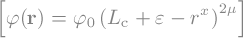

In [10]:
eqns(['varphi_rx_eqn'])

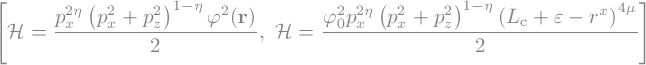

In [11]:
eqns(['H_eqn', 'H_varphi_rx_eqn'])

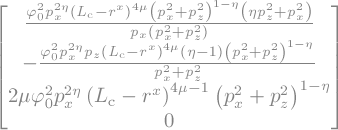

In [12]:
gmeq.hamiltons_eqns.subs({varepsilon:0})

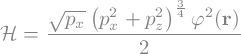

In [13]:
H_from_gstar_eqn = Eq(H, factor( simplify( 
    (gmeq.p_covec_eqn.rhs*(gmeq.gstar_varphi_pxpz_eqn.rhs * gmeq.p_covec_eqn.rhs.T))[0]/2 ) ) )
H_from_gstar_eqn

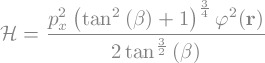

In [14]:
H_tanbeta_px_eqn = factor( H_from_gstar_eqn
                              .subs(e2d(gmeq.pz_px_tanbeta_eqn)) ) \
                        .subs({Abs(tan(beta)):tan(beta), Abs(px):px})
H_tanbeta_px_eqn

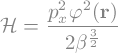

In [15]:
H_smallbeta_px_eqn = simplify(H_tanbeta_px_eqn).subs({cos(beta):1, tan(beta):beta})
H_smallbeta_px_eqn

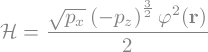

In [16]:
H_from_gstar_eqn.subs({px**2+pz**2:pz**2})

In [17]:
varphi_rx_eqn = gmeq.varphi_rx_eqn.subs({mu:pr.model.mu}).subs(sub)
varphi_rx_eqn

In [18]:
Eq(pz,(pz_0).subs(e2d(gmeq.pz0_xiv0_eqn)).subs(sub))

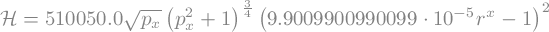

In [19]:
H_px_rx_eqn = simplify(
    H_from_gstar_eqn.subs(e2d(varphi_rx_eqn))
    .subs({pz:pz_0}).subs(e2d(gmeq.pz0_xiv0_eqn)).subs(sub)
)
H_px_rx_lambda = lambdify( (rx,px), H_px_rx_eqn.rhs)
H_px_rx_eqn

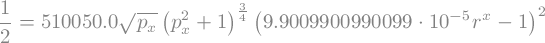

In [20]:
H_px_rx_eqn.subs({H:Rational(1,2)})

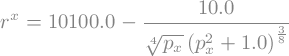

In [21]:
rx_px_eqn = Eq(rx, (solve(H_px_rx_eqn.subs({H:Rational(1,2)}),rx))[0])
rx_px_lambda = lambdify( px, (rx_px_eqn.rhs) )
rx_px_eqn

# Plots

## Prep

In [22]:
gr = SlicingPlots(gmeq.H_Ci_eqn, gmeq.degCi_H0p5_eqn, grid_res=101)

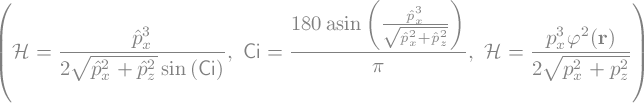

In [23]:
tmp_sub_ = {varepsilonhat:0,rxhat:0,eta:Rational(3,2)}
(
    gmeq.H_Ci_eqn.subs(tmp_sub_), 
    gmeq.degCi_H0p5_eqn.subs(tmp_sub_),
    gmeq.H_eqn.subs(tmp_sub_)
)

In [24]:
pxhat_lambda = lambda sub_, rxhat_, pzhat_: solve(
    gmeq.H_Ci_eqn.subs({rxhat:rxhat_, H:Rational(1,2), mu:eta/2})
        .subs(sub_).n().subs({pzhat:pzhat_}), pxhat)[0]
pzhat_lambda = lambda sub_, rxhat_, pxhat_: (solve(
    gmeq.H_Ci_eqn.subs({rxhat:rxhat_, H:Rational(1,2), mu:eta/2})
        .subs(sub_).subs({pxhat:pxhat_}), pzhat)[0])

In [25]:
def pxhatsqrd_Ci_polylike_eqn(sub_, pzhat0_, ):
    tmp = (gmeq.H_Ci_eqn.rhs.subs({pzhat:pzhat0_, H:Rational(1,2), mu:eta/2})
           .subs(omitdict(sub_,[Ci])))**2
    return Eq(4*numer(tmp)-denom(tmp),0)

def pxhat_Ci_soln(eqn_, sub_, rxhat_, tolerance=1e-3):
    solns_ = Matrix(solve(eqn_.subs(sub_),pxhat**2)).subs({rxhat:rxhat_})
#     print(solns_.n())
#     [print(soln_, Abs(im(soln_))<1e-6, re(soln_),'\n') for soln_ in solns_.n()]
    return float(sqrt(
        [re(soln_) for soln_ in solns_.n() if Abs(im(soln_))<tolerance and re(soln_)>0][0]
    ))

def pxpzhat0_values(contour_values_, sub_):

    pxpzhat0_values_ = [None]*len(contour_values_)
    for i_,Ci_ in enumerate(contour_values_):
        tmp_sub_ = omitdict(sub_,[rxhat,Ci])
        tmp_sub_[Ci] = rad(Ci_)
        pzhat0_ = pzhat_lambda(tmp_sub_,0,1).n()
        eqn_ = pxhatsqrd_Ci_polylike_eqn(tmp_sub_, pzhat0_)
        pxpzhat0_values_[i_] = (
            pxhat_Ci_soln(eqn_, tmp_sub_, rxhat.subs(sub_)),
            pzhat_lambda(tmp_sub_,0,1).n() 
        )
    return pxpzhat0_values_

## Slice $p_x,p_z$ plane for $\eta=3/2$ 

In [26]:
pxpz_list_=(pxhat,pzhat)
eta_ = Rational(3,2)
sub_ = {eta:eta_, varepsilonhat:Rational(1,100), Ci:rad(4)} 

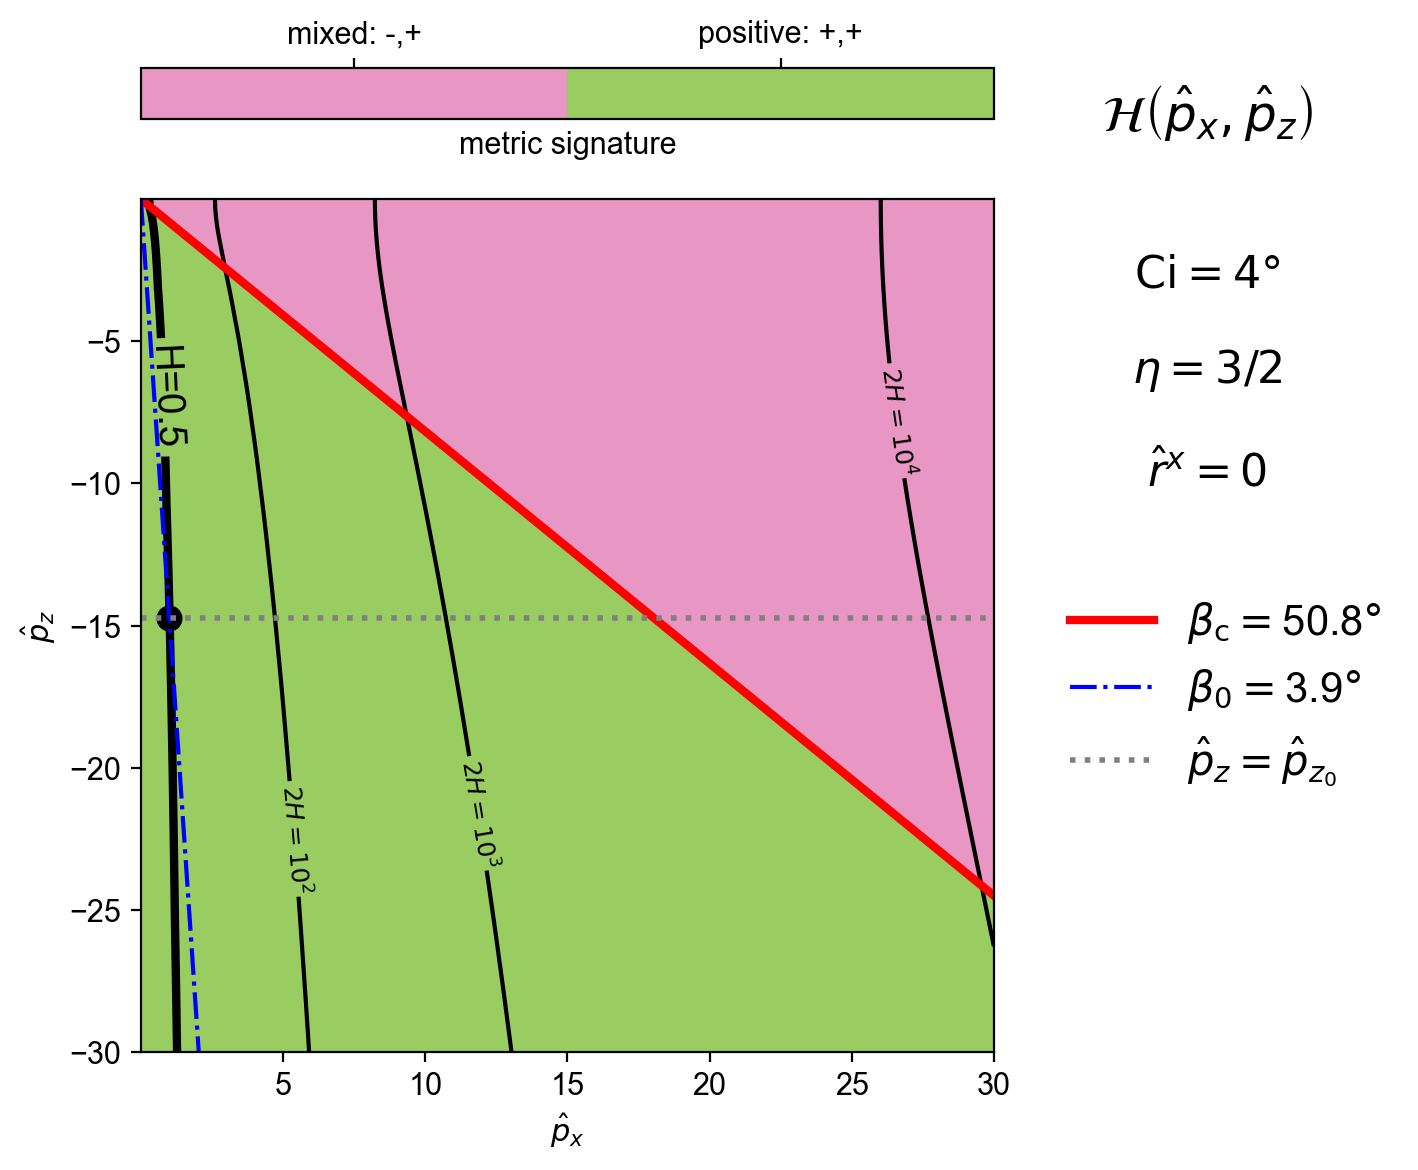

In [27]:
psf_ = 30
sub_[rxhat] = Rational(0,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_values=None, contour_range=[2,5],
                    do_log2H=True, do_Ci=False, do_black_contours=True )
# pxpzhat0_values_

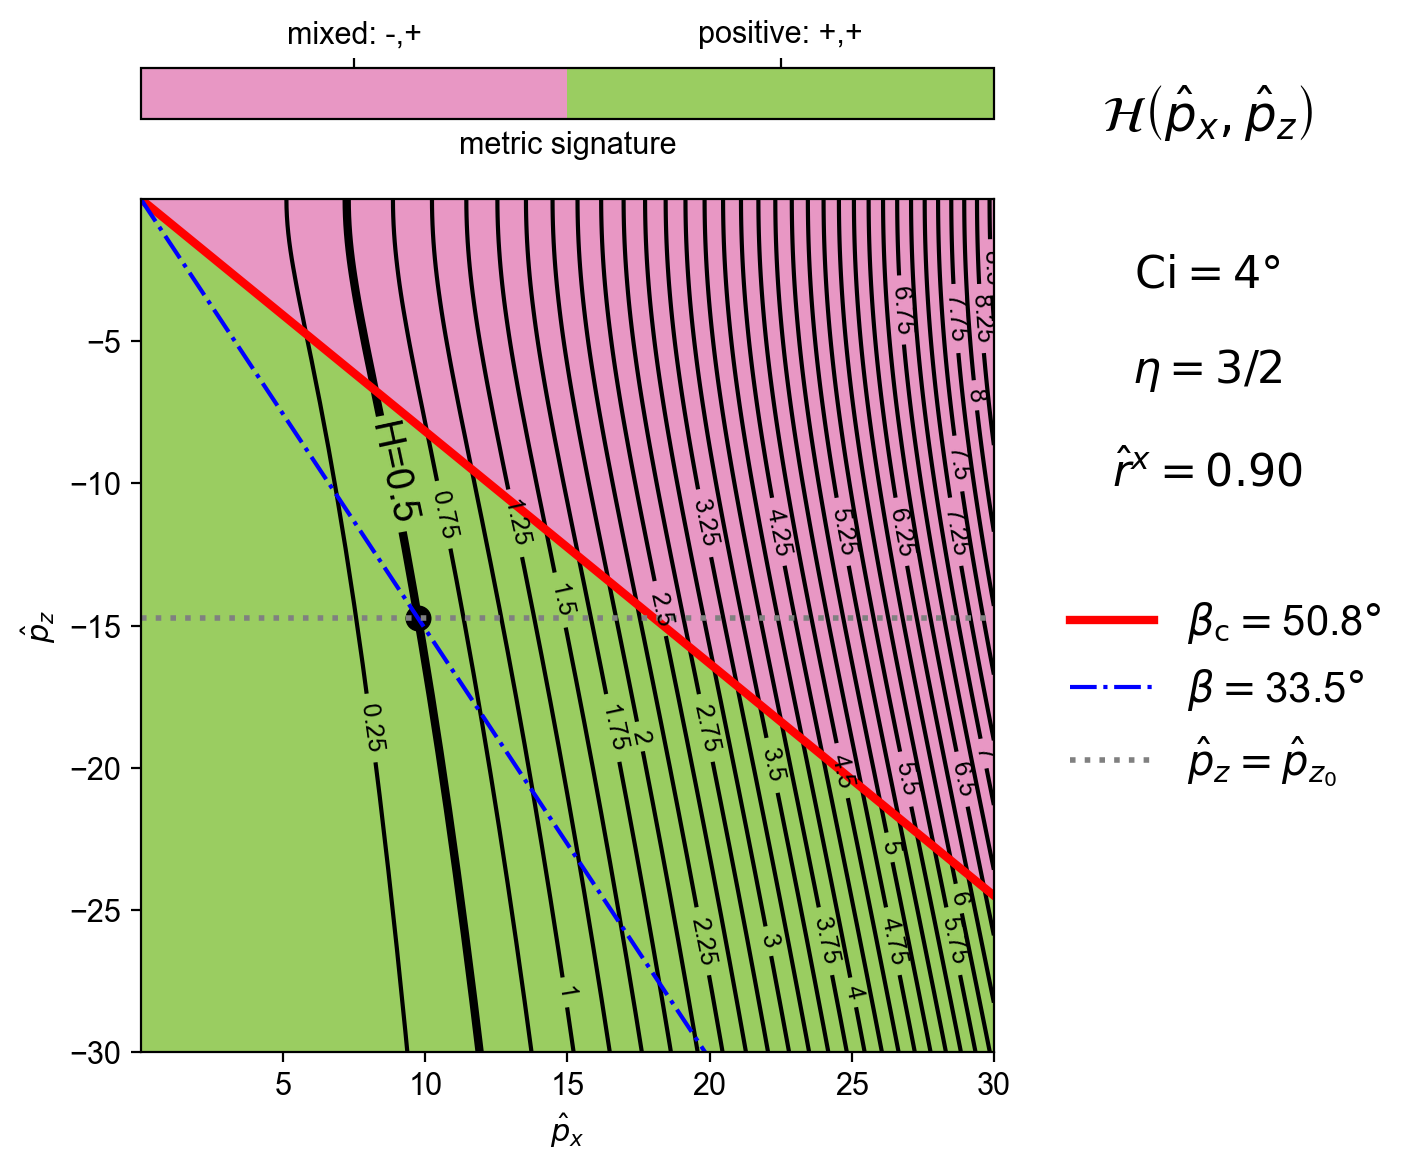

In [28]:
psf_ = 30
sub_[rxhat] = Rational(90,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[2,6+32], contour_range=[0,10],
                    do_black_contours=True )

# contour_values_ = [2,4,8]
# pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
# contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
# gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
#                     gstar_signature_lambda=gstar_pxpz_signature_lambda_,
#                     psf=psf_, pxpz_points=pxpzhat0_values_, 
#                     do_log2H=False, do_Ci=True, 
#                     contour_values=contour_values_,
#                     contour_label_locs=contour_label_locs_ )

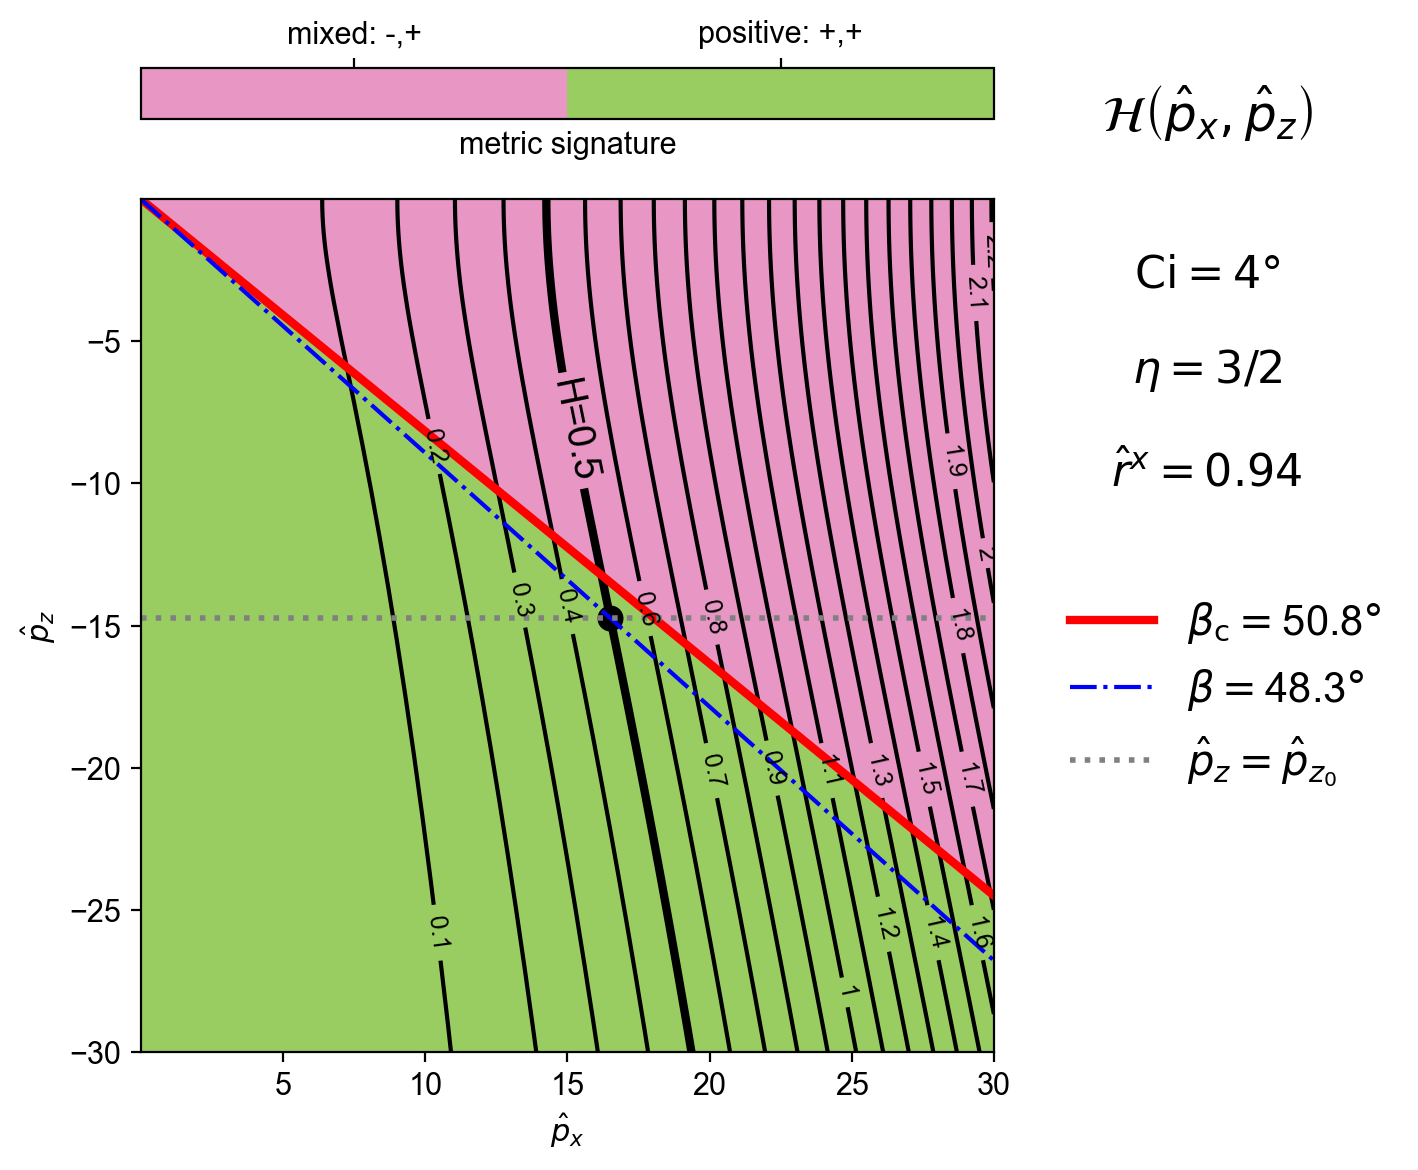

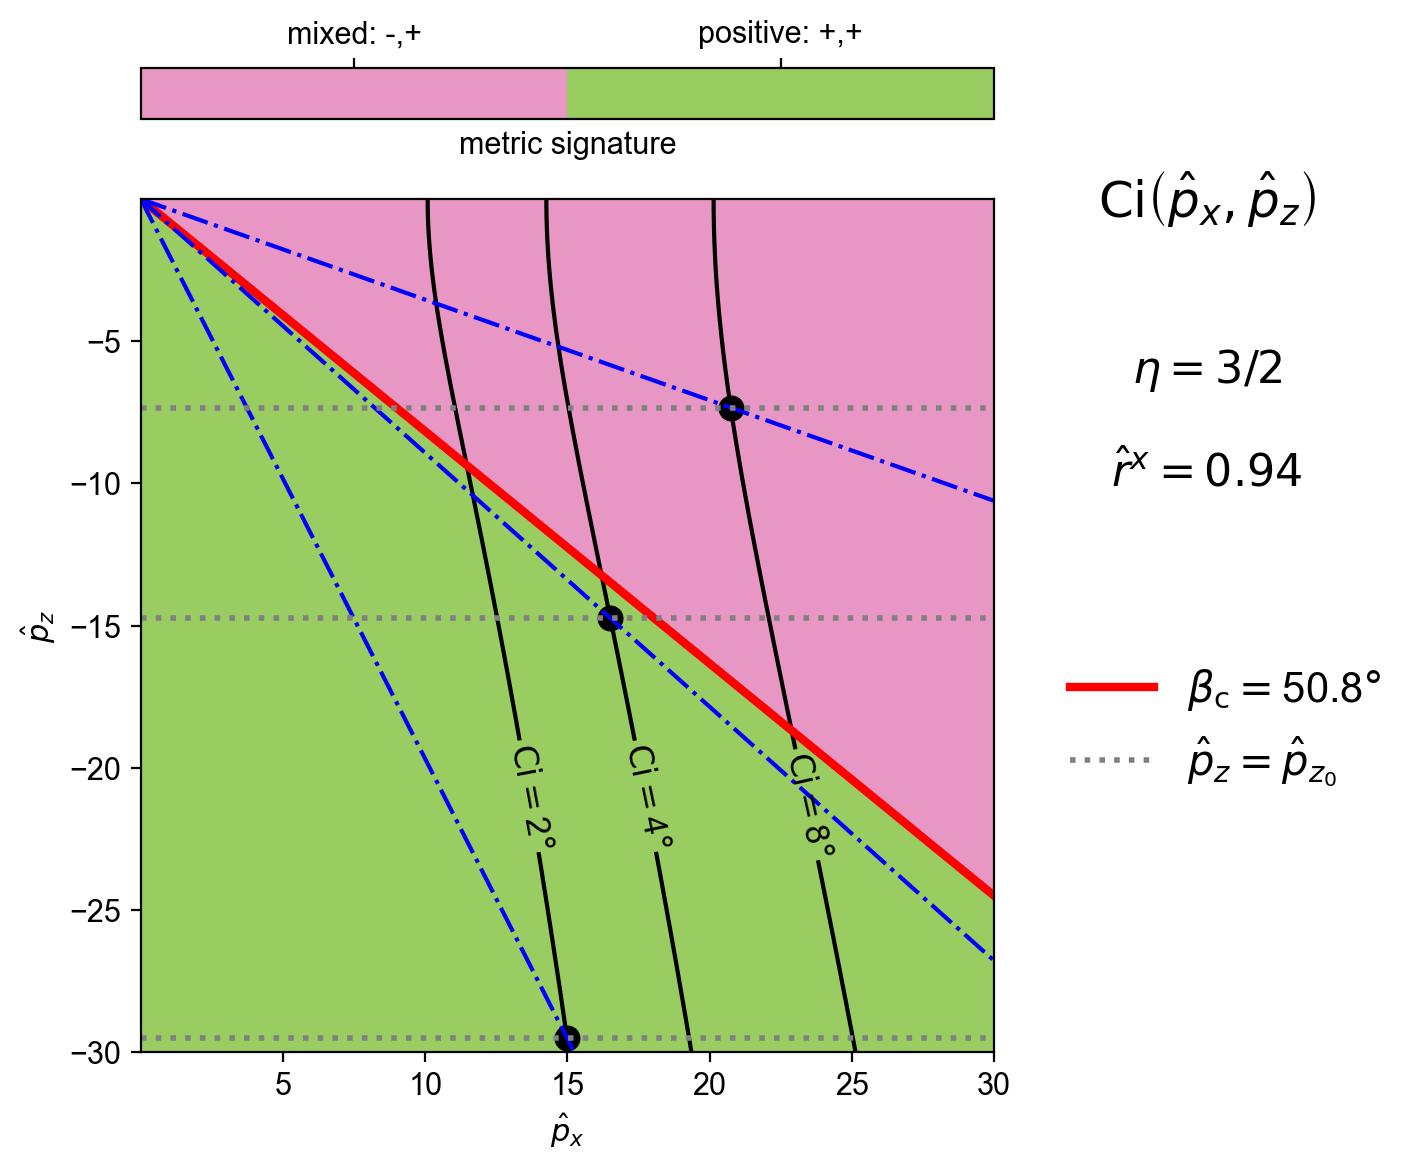

In [29]:
psf_ = 30
sub_[rxhat] = Rational(94,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[5,25], contour_range=[0,3],
                    do_black_contours=True )

contour_values_ = [2,4,8]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    do_log2H=False, do_Ci=True, 
                    contour_values=contour_values_,
                    contour_label_locs=contour_label_locs_ )

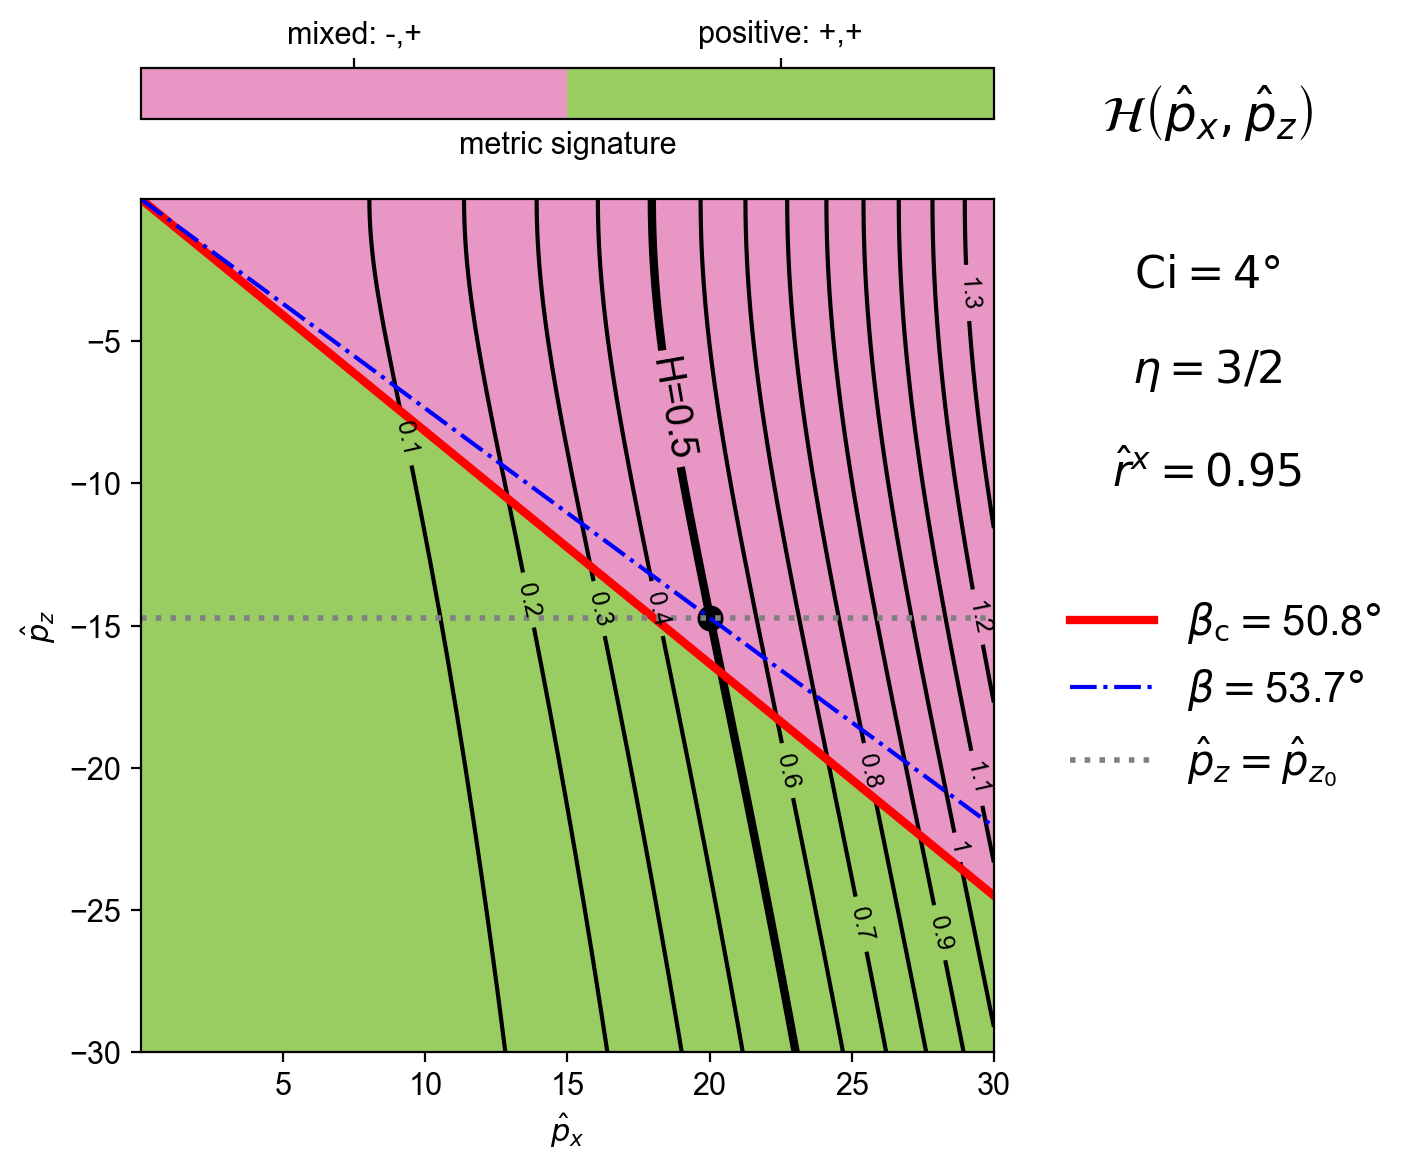

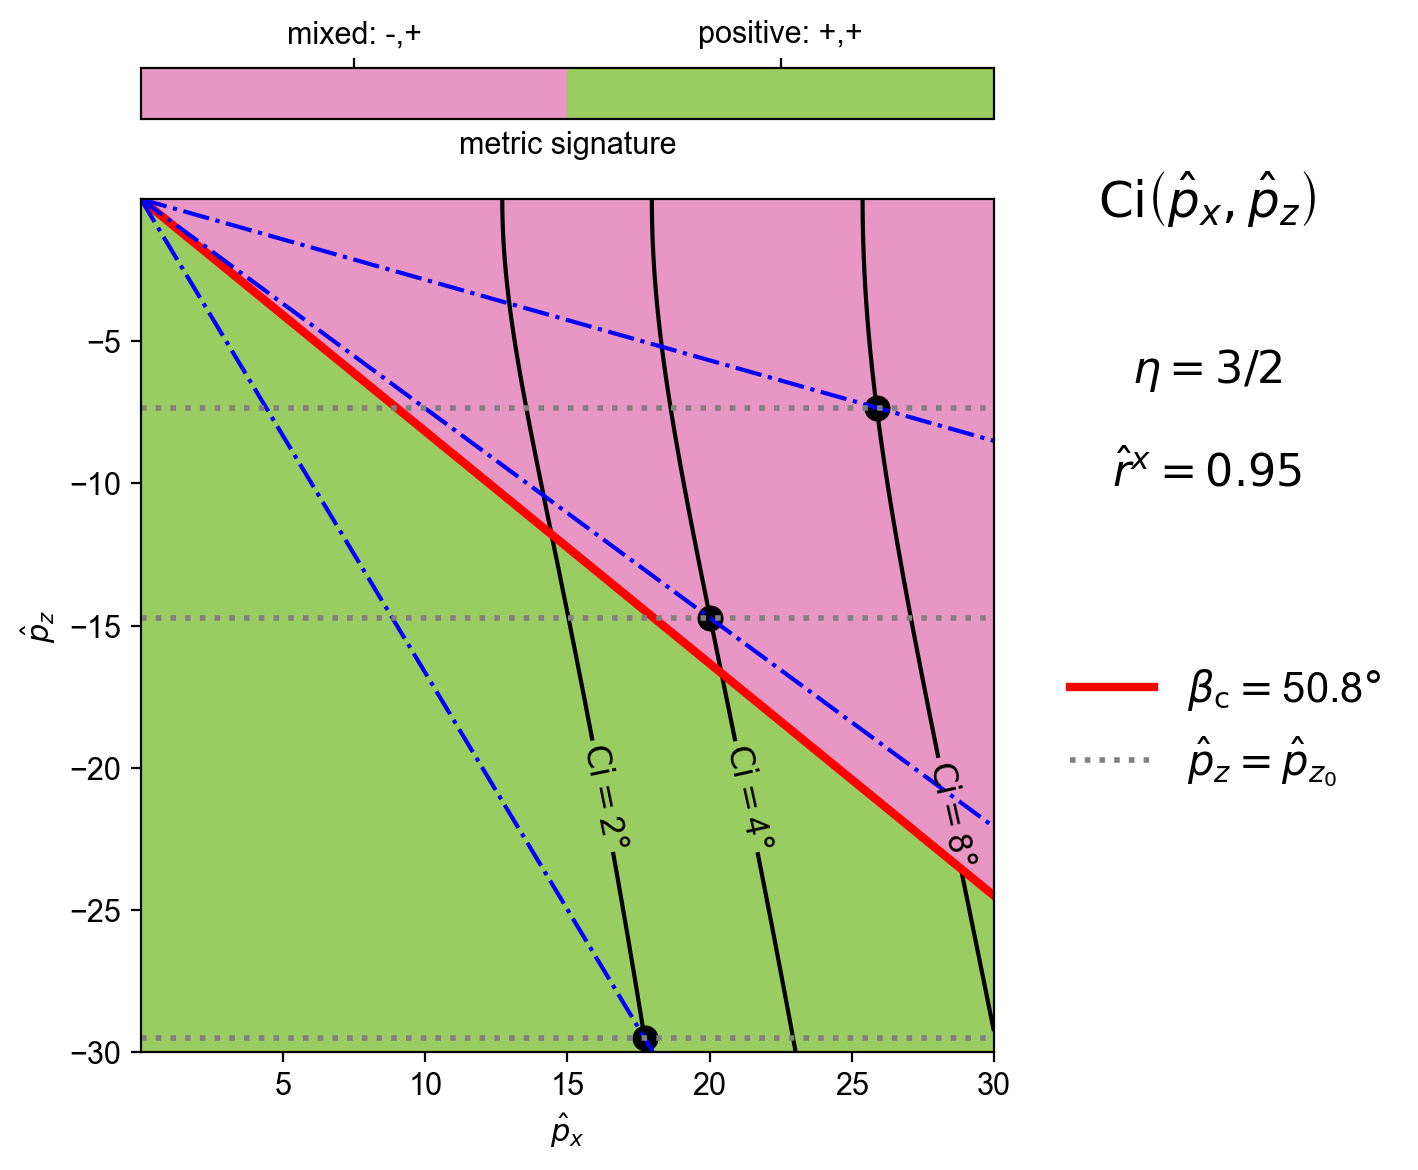

In [30]:
psf_ = 30
sub_[rxhat] = Rational(95,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals( sub_=sub_, var_list=pxpz_list_ )

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[5,15], contour_range=[0,2],
                    do_black_contours=True )

contour_values_ = [2,4,8]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    do_log2H=False, do_Ci=True, 
                    contour_values=contour_values_,
                    contour_label_locs=contour_label_locs_ )

## Slice $p_x,p_z$ plane for $\eta=1/2$

In [31]:
pxpz_list_=(pxhat,pzhat)
eta_ = Rational(1,2)
sub_ = {eta:eta_, varepsilonhat:Rational(1,100), Ci:rad(4)} 

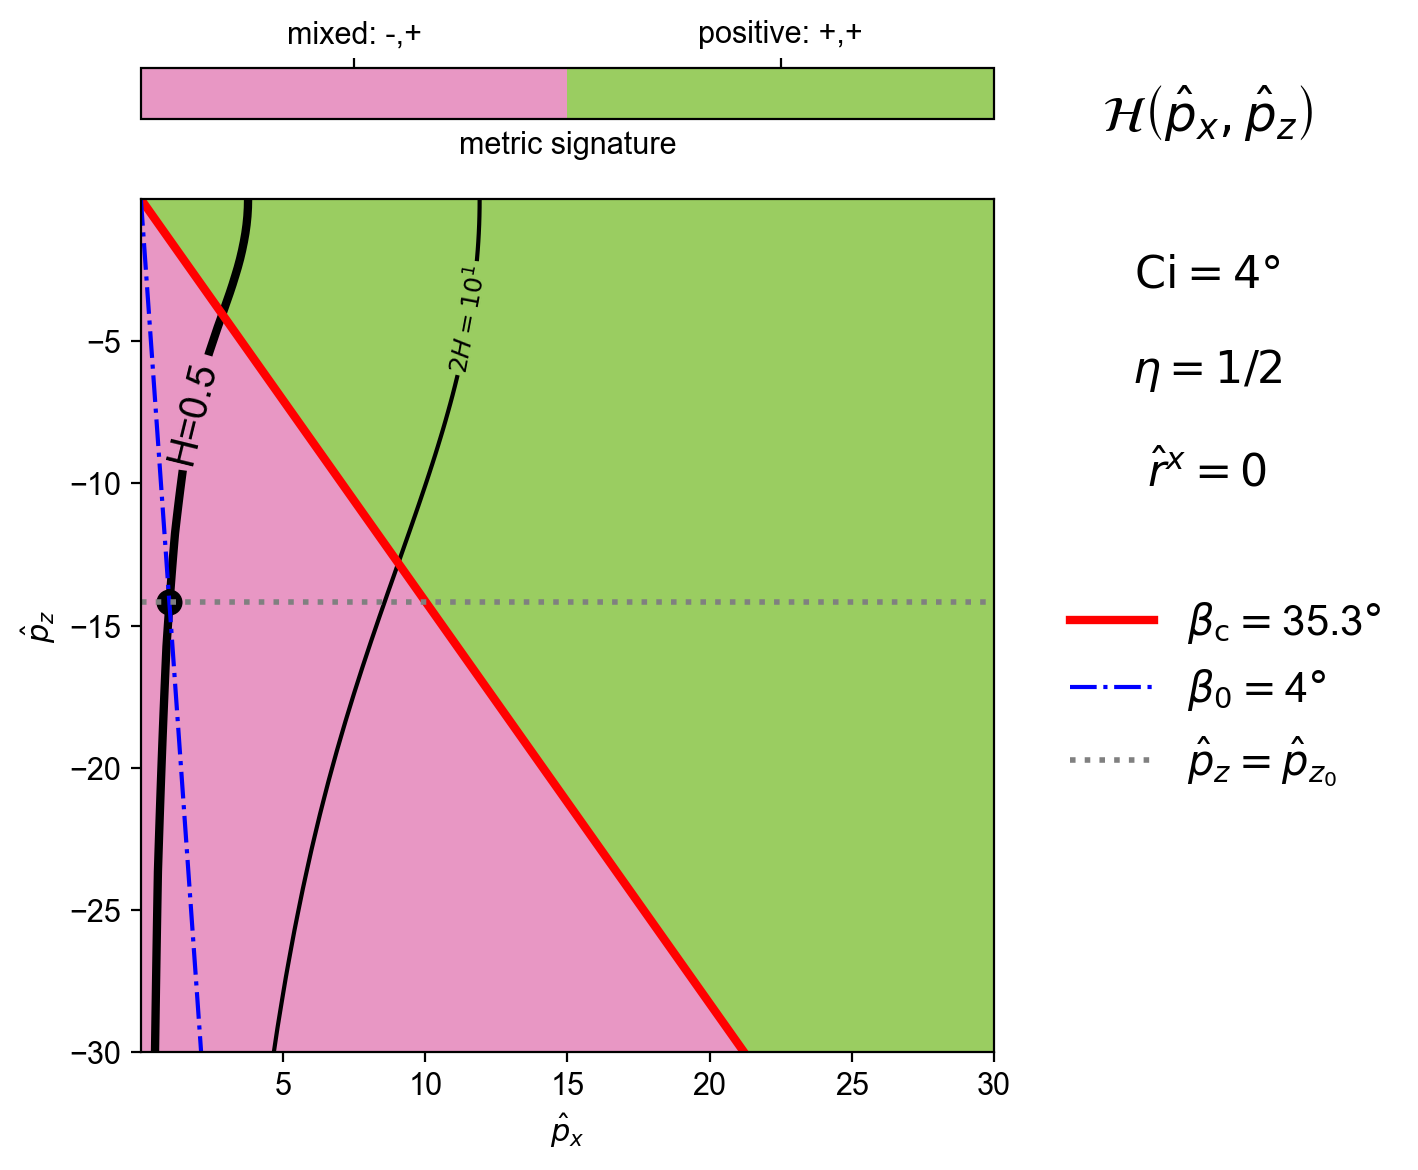

In [32]:
psf_ = 30
sub_[rxhat] = Rational(0,100).n()

H_pxpz_lambda_ = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_values=None, contour_range=[0,4],
                    do_log2H=True, do_Ci=False, do_black_contours=True )

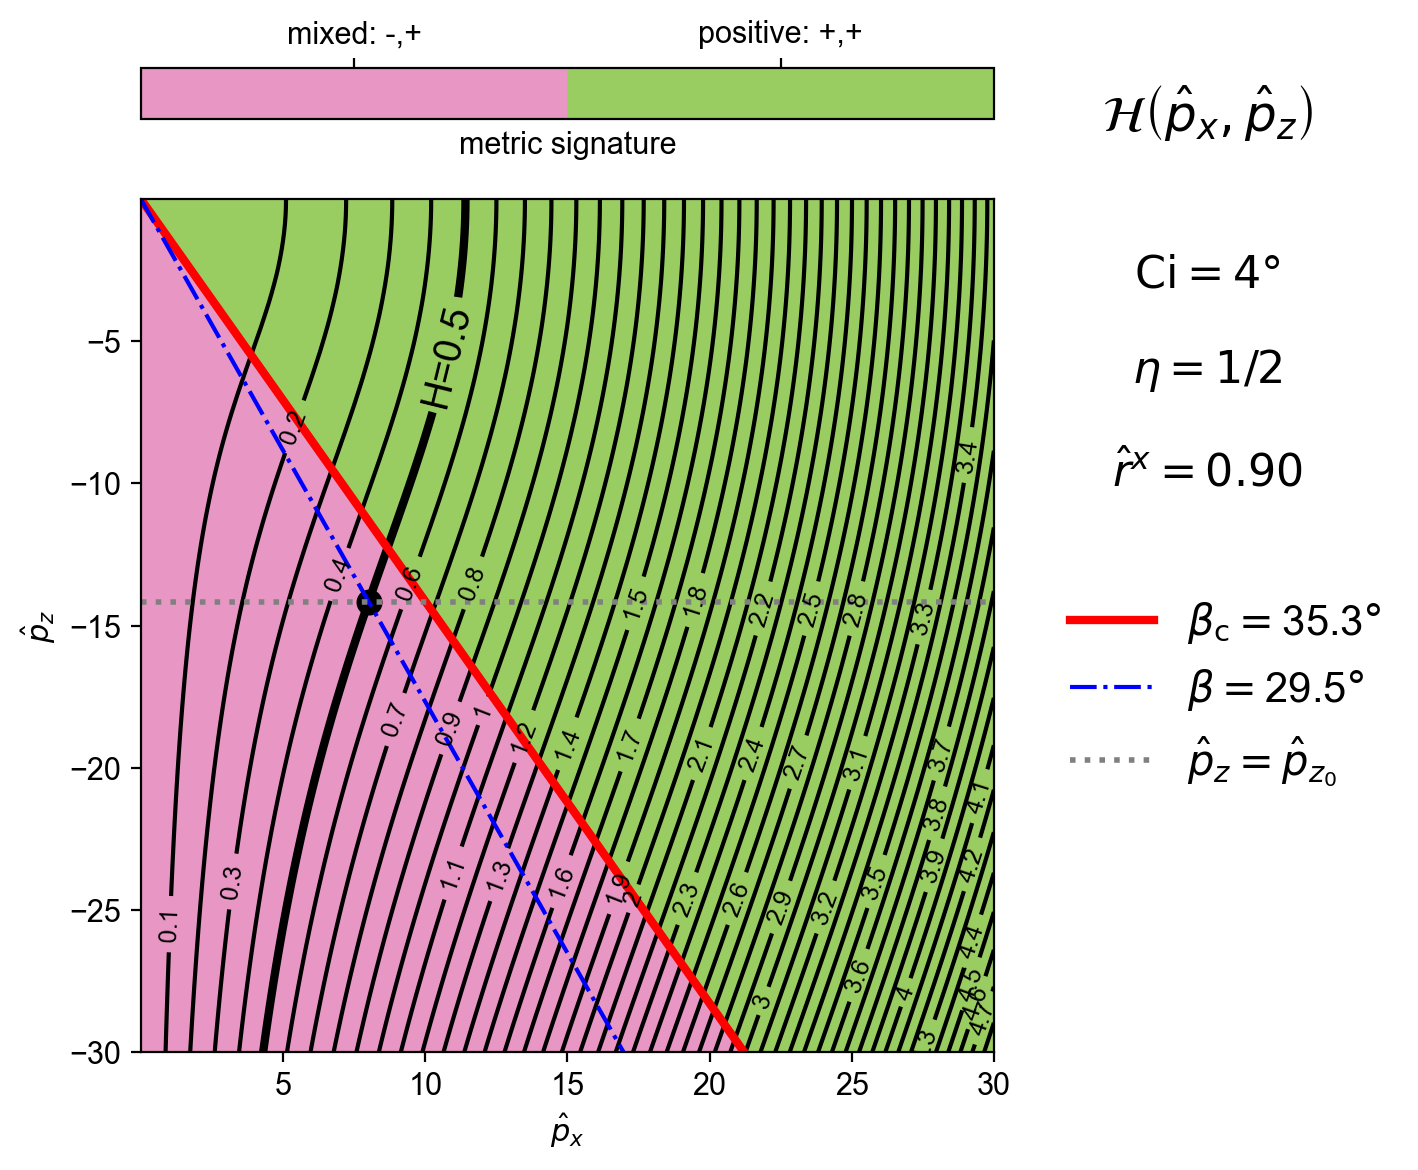

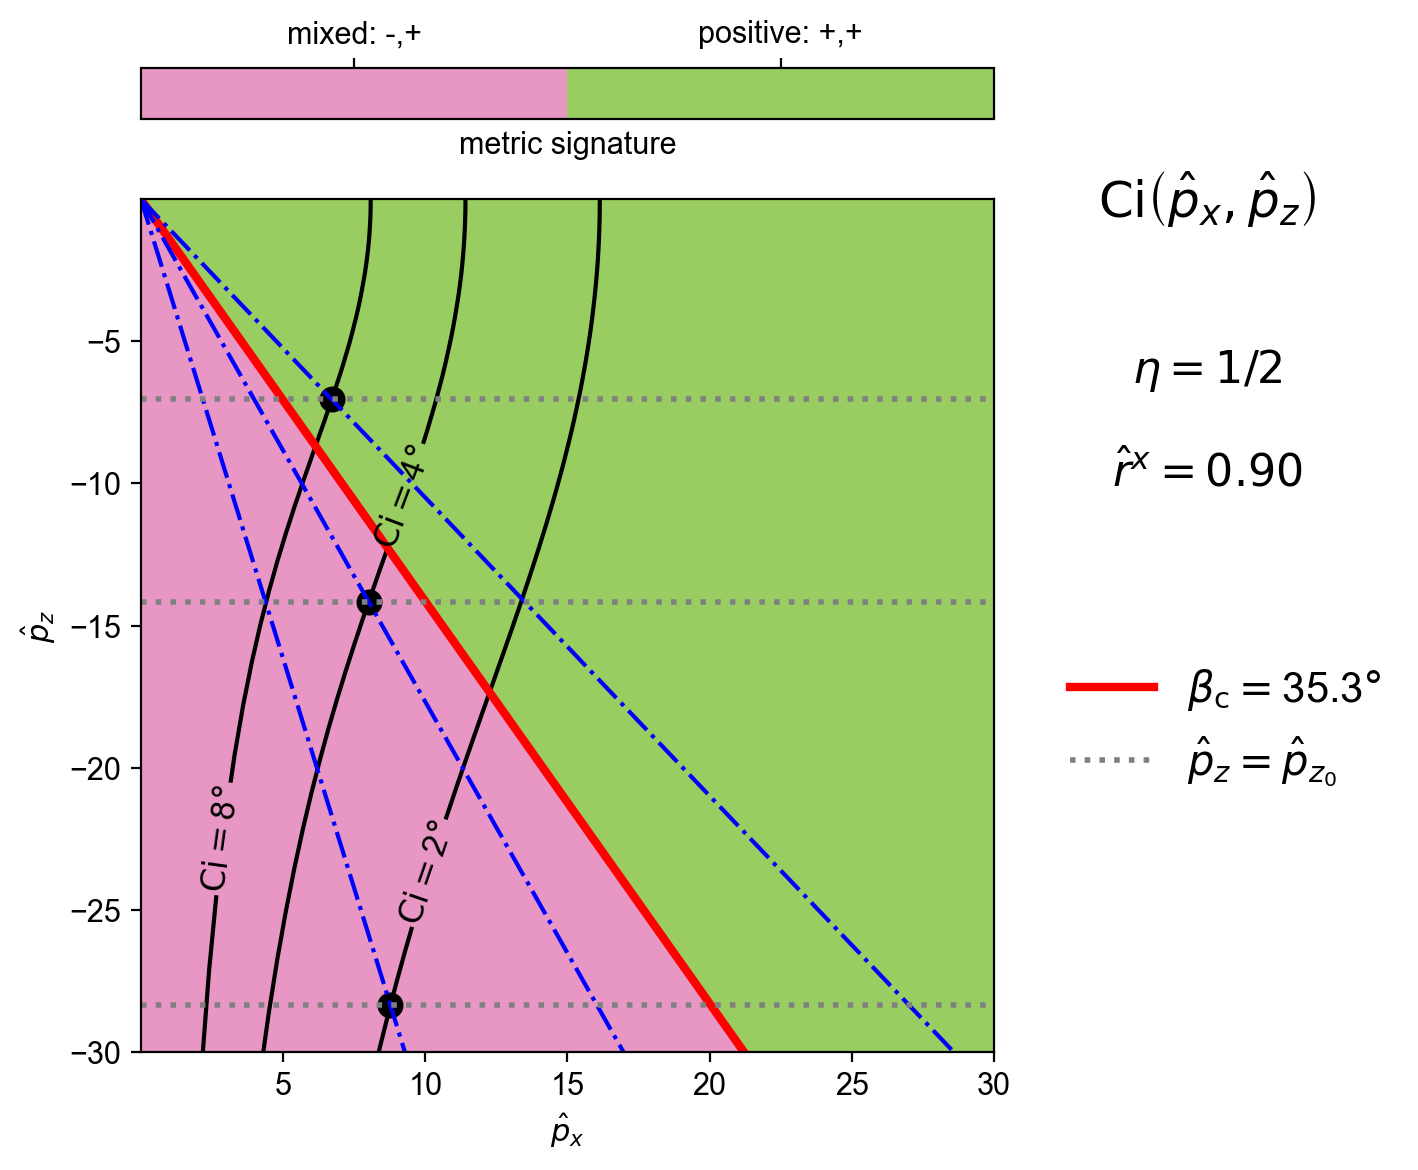

In [33]:
psf_ = 30
sub_[rxhat] = Rational(90,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[5,45], contour_range=[0,5],
                    do_black_contours=True )

contour_values_ = [2,4,8]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    do_log2H=False, do_Ci=True, 
                    contour_values=contour_values_,
                    contour_label_locs=contour_label_locs_ )

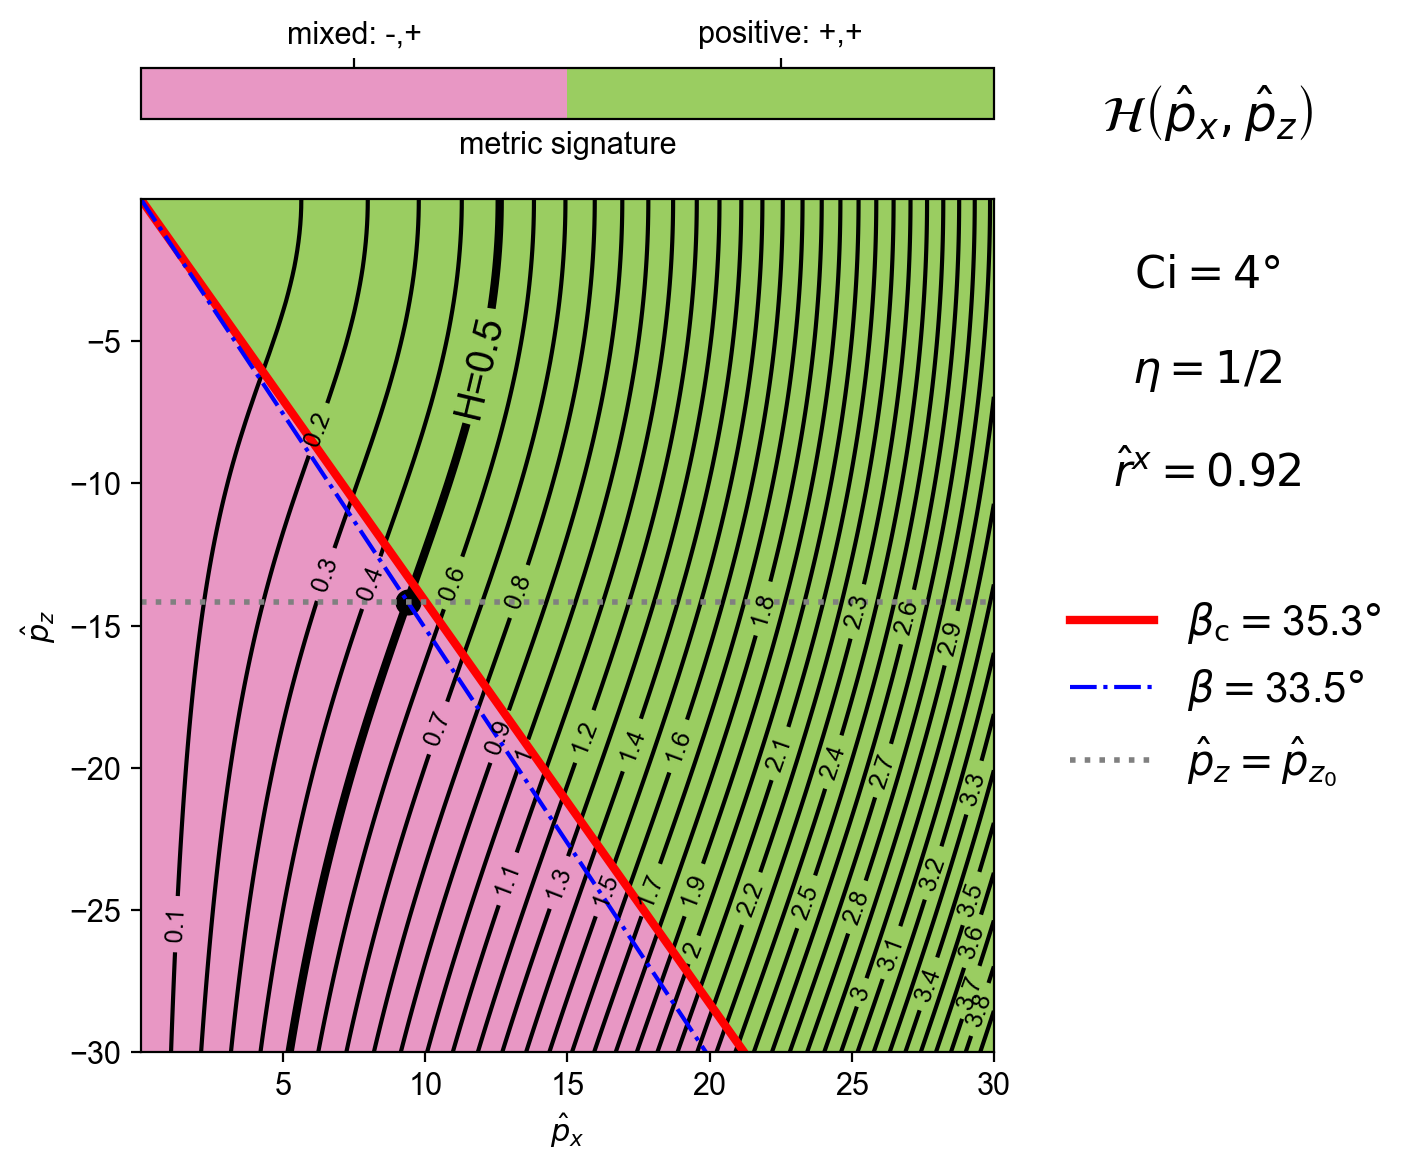

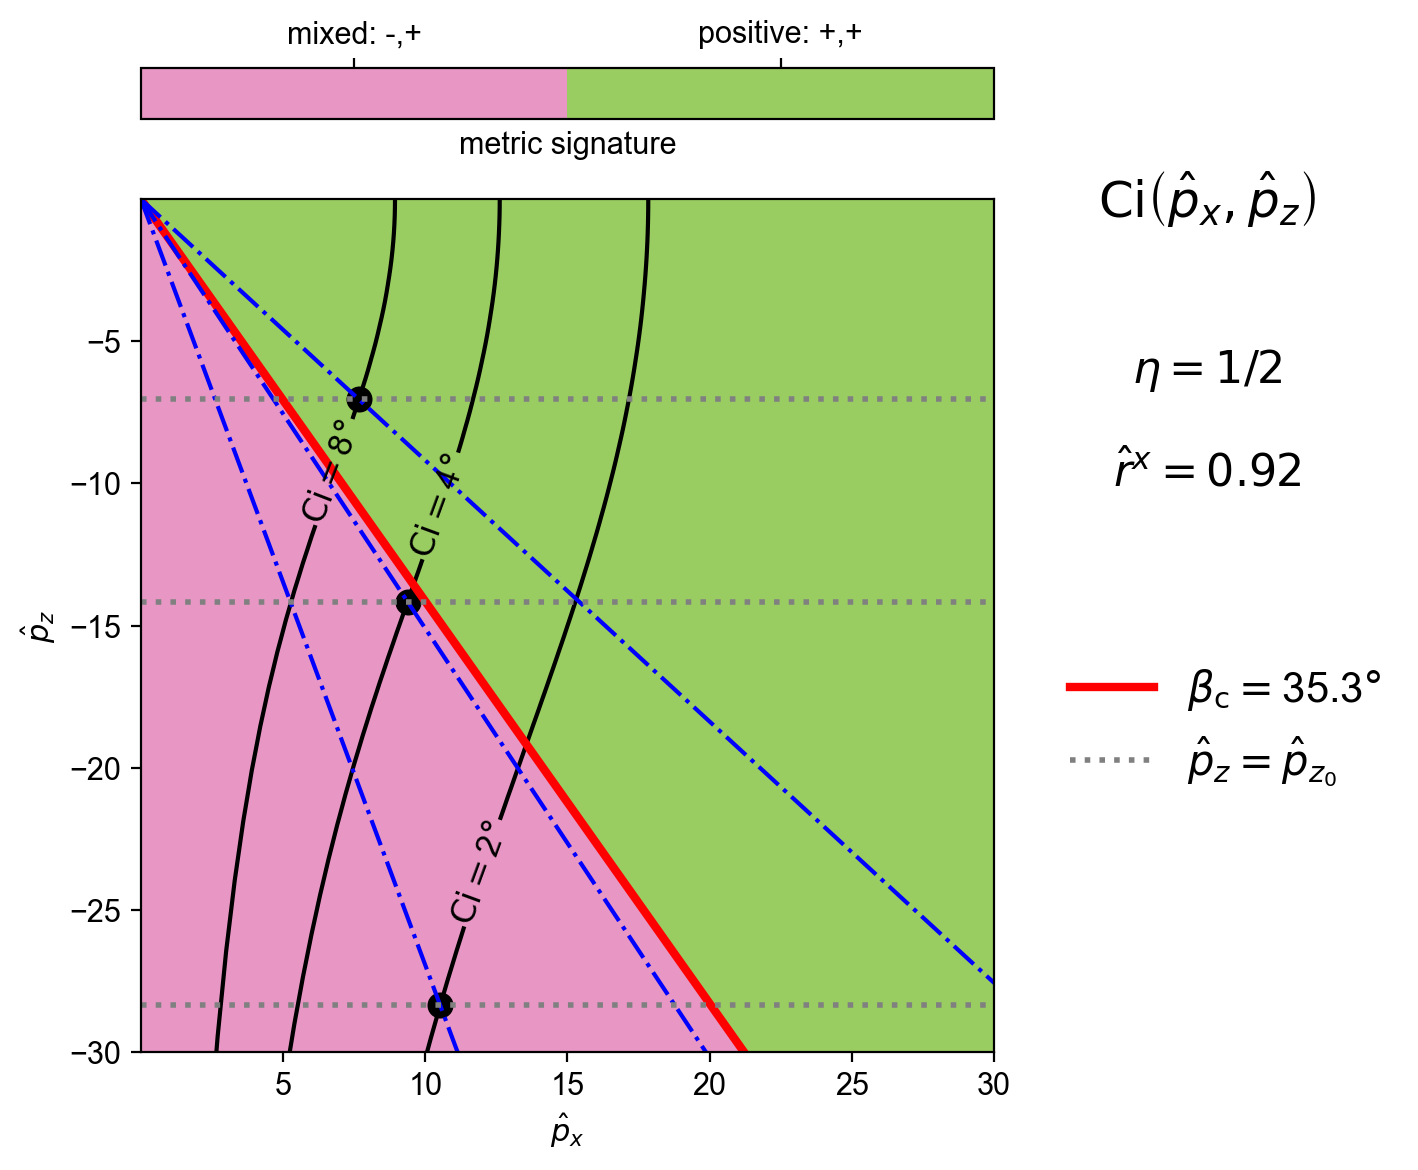

In [34]:
psf_ = 30
sub_[rxhat] = Rational(92,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[5,35], contour_range=[0,4],
                    do_black_contours=True )

contour_values_ = [2,4,8]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    do_log2H=False, do_Ci=True, 
                    contour_values=contour_values_,
                    contour_label_locs=contour_label_locs_ )

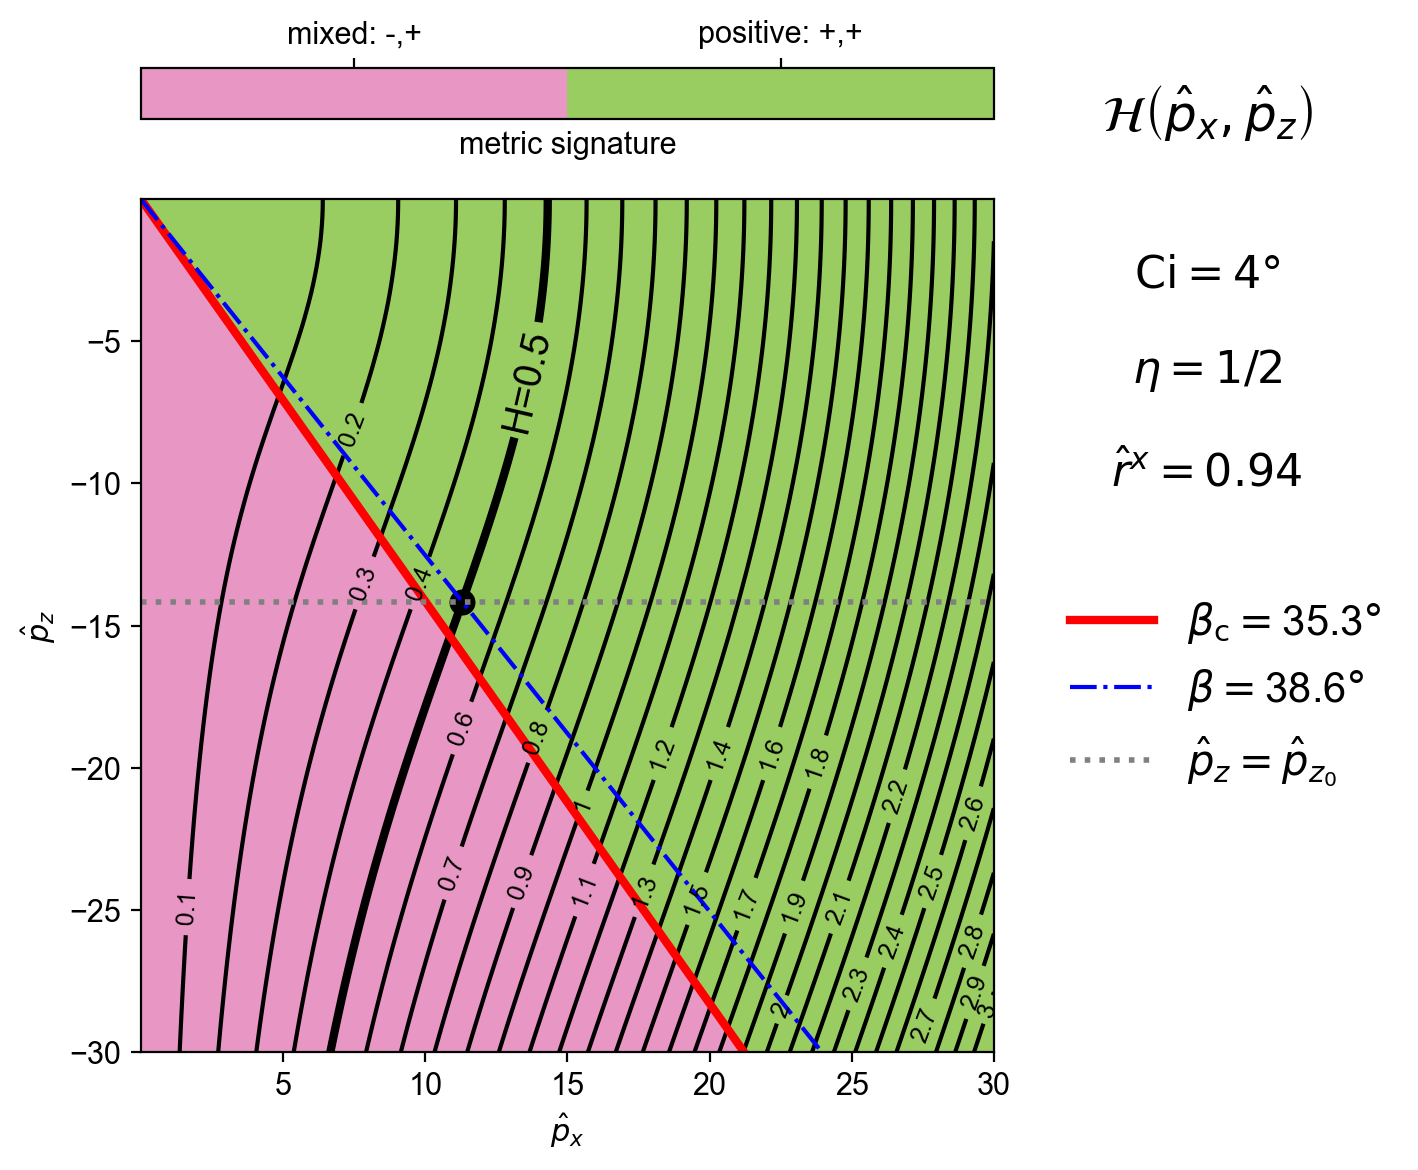

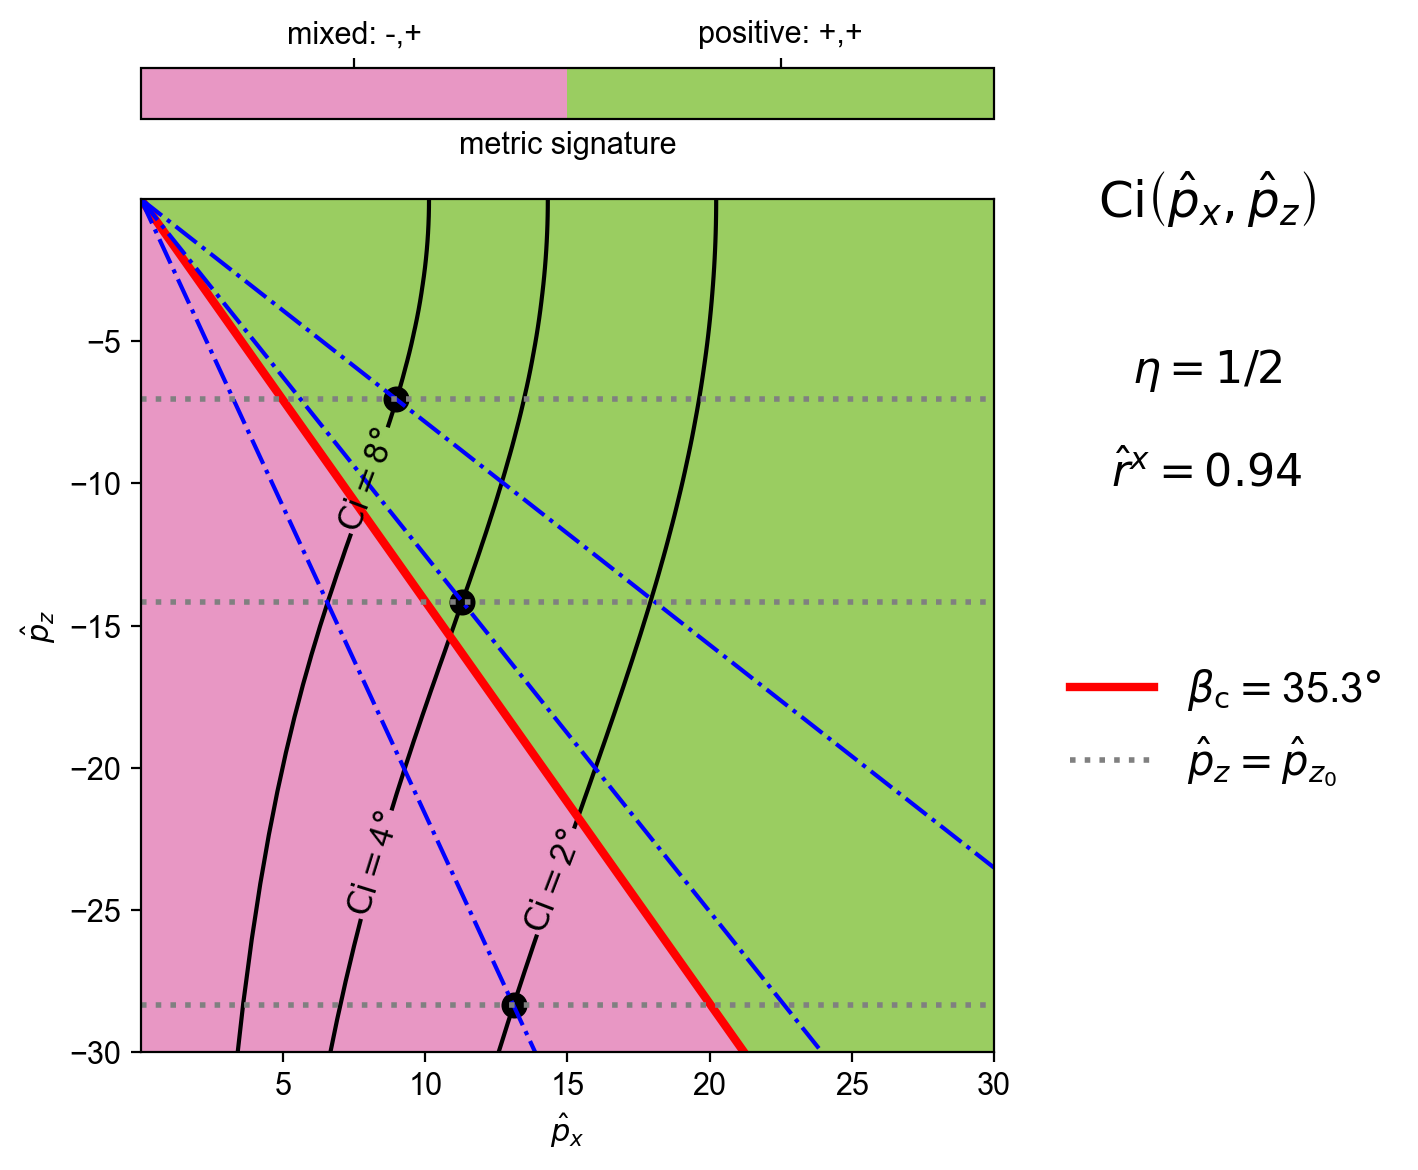

In [35]:
psf_ = 30
sub_[rxhat] = Rational(94,100).n()

H_pxpz_lambda_  = gr.define_H_lambda(sub_=sub_, var_list=pxpz_list_)
Ci_pxpz_lambda_ = gr.define_Ci_lambda(sub_=sub_, var_list=pxpz_list_)
gstar_pxpz_signature_lambda_ = gr.define_Hessian_eigenvals(sub_=sub_, var_list=pxpz_list_)

contour_values_ = [deg(Ci).subs(sub_)]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
gr.H_pxpz_contours( sub_=sub_, H_lambda=H_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    contour_nlevels=[5,25], contour_range=[0,3],
                    do_black_contours=True )

contour_values_ = [2,4,8]
pxpzhat0_values_ = pxpzhat0_values(contour_values_, sub_)
contour_label_locs_ = None #[(0.5,-9), (0.75,-6.5), (1.,-4)]
gr.H_pxpz_contours( sub_=sub_, Ci_lambda=Ci_pxpz_lambda_, 
                    gstar_signature_lambda=gstar_pxpz_signature_lambda_,
                    psf=psf_, pxpz_points=pxpzhat0_values_, 
                    do_log2H=False, do_Ci=True, 
                    contour_values=contour_values_,
                    contour_label_locs=contour_label_locs_ )

# Save

Export the graphs as PNG and/or PDF image files.

In [36]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "H_pslice_eta1p5_rxhat0.png"
Exported "H_pslice_eta1p5_rxhat0p9.png"
Exported "H_pslice_eta1p5_rxhat0p94.png"
Exported "Ci_pslice_eta1p5_rxhat0p94.png"
Exported "H_pslice_eta1p5_rxhat0p95.png"
Exported "Ci_pslice_eta1p5_rxhat0p95.png"
Exported "H_pslice_eta0p5_rxhat0.png"
Exported "H_pslice_eta0p5_rxhat0p9.png"
Exported "Ci_pslice_eta0p5_rxhat0p9.png"
Exported "H_pslice_eta0p5_rxhat0p92.png"
Exported "Ci_pslice_eta0p5_rxhat0p92.png"
Exported "H_pslice_eta0p5_rxhat0p94.png"
Exported "Ci_pslice_eta0p5_rxhat0p94.png"
